In [62]:
import glob
import pickle
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family']='Helvetica'

In [7]:
from keras.models import Model, Sequential
from keras.layers import Conv1D,LSTM,Bidirectional,GRU,Input,Dropout,BatchNormalization,Reshape,Activation


In [60]:
def generate_gaussian(length,mean,std):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2):
    y_label = np.zeros((30000))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        y = generate_box(data['Pn'],data['Sn'])
    if data['Pg']!=0:
        y = generate_box(data['Pg'],data['Sg'])
    return x,y

def plot_example(x,y):
    plt.figure(figsize=(15,6))    
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y)
        plt.xlim(0,30000)
        
def load_multiple(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob('data*pkl')[:m]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,30000))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:] = x
        Y[i,:]   = y
    return X,Y

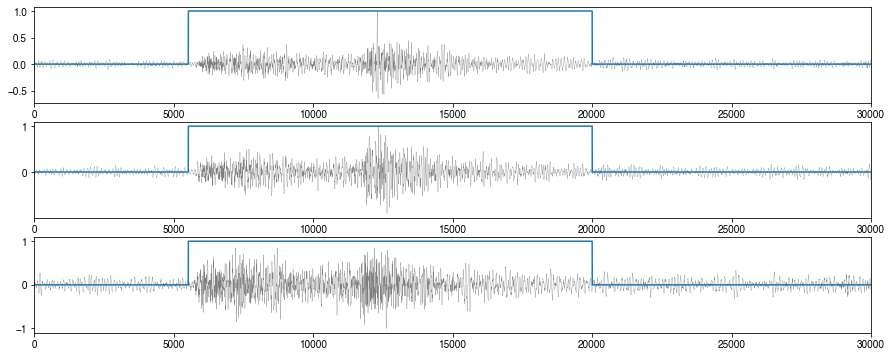

In [59]:
x1,y1 = create_training_example('data__Pn_3016.pkl')
plot_example(x1,y1)

In [64]:
X_train,Y_train = load_multiple(100)
print(X_train.shape,Y_train.shape)

(100, 3, 30000) (100, 30000)


In [ ]:
def model(input_shape):
    
    
    X_input=Input(shape=input_shape)
    
    # A dense block
    X = Conv1D(filters=196,kernel_size=100,stride=5)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)
    
    
    
    